This notebook does 2 things:

1. Applies different resenet architectures and selects the
   model and architecture based on the validation loss.

1. Calculates AUC ROC score fo the best model.

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from fastai2.metrics import RocAuc
from fastai2.vision.all import *



In [2]:
dblock = DataBlock(get_x = lambda r: f"data/jpeg/train{r['image_name']}",
                  get_y = lambda r : r["target"],)

train_df = pd.read_csv('data/train.csv')

train_df.target.value_counts()

train_df = train_df.sample(n = 1000)

dblock = DataBlock((ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(0.3,42),
                   get_x = lambda r: f"data/jpeg/train/{r['image_name']}.jpg",
                   get_y = lambda r : str(r["target"]),
                   item_tfms = Resize(size=224))


dls = dblock.dataloaders(train_df,bs=128)

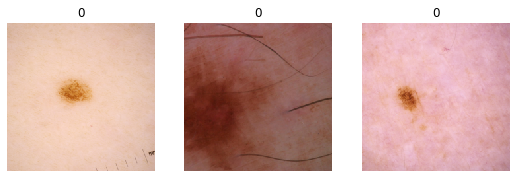

In [3]:
dls.show_batch(nrows=1, ncols=3)

In [4]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet18-5c106cde.pth


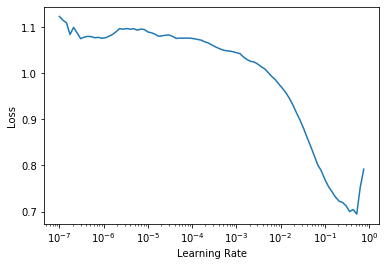

In [65]:
output = learn.lr_find(num_it=100)

In [66]:
print(output)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.05754399299621582)


In [12]:
learn.fit_one_cycle(n_epoch=6, lr=5e-2)

epoch,train_loss,valid_loss,time
0,1.045181,1.102828,04:05
1,1.009149,0.841568,04:15
2,0.979844,0.669086,04:23
3,0.954485,0.641952,03:06
4,0.925379,0.620657,02:17
5,0.907805,0.626170,02:07


In [13]:
learn.save('fit-one-cycle-6-epochs')

In [19]:
dls = dblock.dataloaders(train_df,bs=256)

learn = cnn_learner(dls, resnet18)

learn.load('fit-one-cycle-6-epochs')

In [20]:
learn.unfreeze()

In [ ]:
learn.lr_find()